In [1]:
%reload_ext autoreload
%autoreload 2

In [12]:
# import modules 
import sys
sys.path.append(".")
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


from DecodeSNC_CViter import DecodeSNC_CViter
sys.path.append("../fMRI_Processing")
import fit_IEM_v1 as IEM
import fit_IEM_v2 as IEM2
import pycircstat
ccorr = pycircstat.corrcc
from circ_corr import circ_corrcc_better as c_corr

import seaborn as sns
from matplotlib import rc
font = {'family':'DejaVu Sans','size'   : 16}
from multiprocessing import Pool
rc('font', **font)

In [3]:
def nanc_corr(x,y):
    good_x = ~np.isnan(x)
    x=x[good_x]
    y=y[good_x]
    good_y = ~np.isnan(y)
    x=x[good_y]
    y=y[good_y]
    return c_corr(x,y)

# Import and extract data

In [4]:
import pandas as pd
subj = 'UCSD060'
dat_loc = '/mnt/neurocube/local/serenceslab/tsheehan/CD_Task/SignalProcessing/' + subj +'_dat.pickle'
dat = pd.read_pickle(dat_loc)
D_LOC = dat['DAT_LOC']
E_LOC = dat['EV_LOC']
D_TASK = dat['DAT_TASK']
E_TASK = dat['EV_TASK']

# Select Voxels from localizer and Task

In [5]:
DC_LOC = pd.Series() # dat clean localizer
DC_TASK = pd.Series() # dat clean task

donut = 50
ori = 50 # or hard vox
max_vox = 100
roi = 'V1'
for roi in D_LOC.keys():
    print(roi)
    this_dat = D_LOC[roi] # roi x EV
    print('Initial Localizer Data:',this_dat.shape)
    ind_roi_use = np.arange(this_dat.shape[0])

    # Donut loc
    E_LOC.head() # d1- 1.0-donut, 2.0- hole
    dat_out = this_dat[:,E_LOC.d1==1.0]
    dat_in = this_dat[:,E_LOC.d1==2.0]
    t_scores,_ = stats.ttest_ind(dat_out.T,dat_in.T)
    cutoff_donut = np.percentile(t_scores,donut)
    dat_use_0 = dat_out[t_scores>cutoff_donut,:]
    ind_roi_use = ind_roi_use[t_scores>cutoff_donut]
    print('Donut Selective Localizer Data:', dat_use_0.shape)

    # angle loc
    E_Donut = E_LOC[E_LOC.d1==1.0]
    angles_anova =  np.round((E_Donut.d0-10)/2,-1) 
    f_stats = IEM2.anova1(dat_use_0,angles_anova) # NB: Circularity here, will need to bootstrap! 
    n_vox,_ = dat_use_0.shape
    n_keep = np.minimum(100,n_vox*ori/100)
    cutoff_pct_anova = 100*(1-n_keep/n_vox)
    cutoff_anova =  np.percentile(f_stats,cutoff_pct_anova)
    dat_use_1 = dat_use_0[f_stats>cutoff_anova,:].T
    ind_roi_use = ind_roi_use[f_stats>cutoff_anova]
    print('Final Localizer data: ',dat_use_1.shape)

    # grab task data
    dat_use_task = D_TASK[roi][ind_roi_use,:].T
    print('Final Task data: ',dat_use_task.shape)
    
    # make master data-holder
    DC_LOC[roi] = dat_use_1
    DC_TASK[roi] = dat_use_task
    
DC_TASK_T = pd.Series()
DC_LOC_T = pd.Series()
for k in DC_TASK.keys():
    DC_TASK_T[k] = DC_TASK[k].T
    DC_LOC_T[k] = DC_LOC[k].T

TO
Initial Localizer Data: (528, 252)
Donut Selective Localizer Data: (264, 168)
Final Localizer data:  (168, 100)
Final Task data:  (408, 100)
V3
Initial Localizer Data: (2745, 252)
Donut Selective Localizer Data: (1372, 168)
Final Localizer data:  (168, 100)
Final Task data:  (408, 100)
IPS
Initial Localizer Data: (3866, 252)
Donut Selective Localizer Data: (1933, 168)
Final Localizer data:  (168, 100)
Final Task data:  (408, 100)
LO
Initial Localizer Data: (601, 252)
Donut Selective Localizer Data: (300, 168)
Final Localizer data:  (168, 100)
Final Task data:  (408, 100)
hv4
Initial Localizer Data: (564, 252)
Donut Selective Localizer Data: (282, 168)
Final Localizer data:  (168, 100)
Final Task data:  (408, 100)
VO
Initial Localizer Data: (577, 252)
Donut Selective Localizer Data: (288, 168)
Final Localizer data:  (168, 100)
Final Task data:  (408, 100)
V2
Initial Localizer Data: (1734, 252)
Donut Selective Localizer Data: (867, 168)
Final Localizer data:  (168, 100)
Final Task dat

# Train and Test Localizer SNC

In [8]:
# set up a few variables here for dealing with LOO-CV
OUT_LOC_LOC = pd.Series()
p = {"nchans" : 8, "span" : 180, "ninit" : 30}
p['stimfeat'] = E_Donut.d0.values
p['runNs'] = E_Donut.block.values
runs = np.unique(p['runNs'])
for roi in DC_LOC.keys():
# for roi in ['V3']:
    print(roi)
    p['samples'] = DC_LOC[roi]# should be trials by voxels
    est = np.full(p["runNs"].shape, np.nan)
    unc = np.full(p["runNs"].shape, np.nan)
    Pest=[]
    
    for testrun_idx in np.arange(0,len(runs)):
        p["test_trials"] = (p["runNs"]==runs[testrun_idx])
        OUT = DecodeSNC_CViter(p["samples"], p);  
        est[p["test_trials"]], unc[p["test_trials"]],out  = OUT
        print(testrun_idx,'Complete')
    OUT_LOC_LOC[roi] = pd.Series({'est':est,'unc':unc})

TO


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


0 Complete
1 Complete
2 Complete
3 Complete
Failed: 1
4 Complete
5 Complete
6 Complete
V3
Failed: 1
Failed: 2
Failed: 3
0 Complete
Failed: 1
Failed: 2
1 Complete
2 Complete
Failed: 1
3 Complete
4 Complete
Failed: 1
5 Complete
Failed: 1
Failed: 2
Failed: 3
Failed: 4
6 Complete
IPS
Failed: 1
Failed: 2
Failed: 3
Failed: 4
Failed: 5
Failed: 6
Failed: 7
Failed: 8
0 Complete
Failed: 1
Failed: 2
Failed: 3
1 Complete
Failed: 1
Failed: 2
Failed: 3
Failed: 4
2 Complete
3 Complete
Failed: 1
4 Complete
Failed: 1
5 Complete
6 Complete
LO
0 Complete
1 Complete
2 Complete
3 Complete
4 Complete
5 Complete
6 Complete
hv4
Failed: 1
Failed: 2
0 Complete
1 Complete
2 Complete
3 Complete
Failed: 1
4 Complete
5 Complete
6 Complete
VO
0 Complete
1 Complete
2 Complete
Failed: 1
3 Complete
4 Complete
Failed: 1
5 Complete
6 Complete
V2
Failed: 1
0 Complete
1 Complete
2 Complete
Failed: 1
3 Complete
4 Complete
5 Complete
6 Complete
V1
0 Complete
1 Complete
2 Complete
3 Complete
4 Complete
5 Complete
6 Complete
A

# Visualize for given ROI

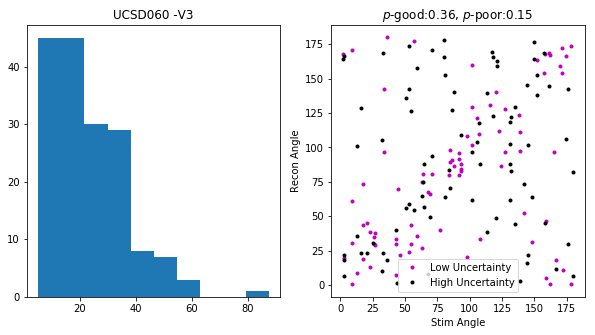

In [7]:
roi = 'V3'
dat = OUT_LOC_LOC[roi]
stimfeat = p['stimfeat']
use = ~np.isnan(dat.unc)
est_use = dat['est'][use]
unc_use = dat['unc'][use]
stimfeat_use=stimfeat[use]
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(unc_use)
plt.title('%s -%s' %(subj,roi))
plt.subplot(122)

good= unc_use<np.median(unc_use)
plt.plot(stimfeat_use[good],est_use[good],'m.')
plt.plot(stimfeat_use[~good],est_use[~good],'k.')
plt.xlabel('Stim Angle')
plt.ylabel('Recon Angle')
plt.legend(('Low Uncertainty','High Uncertainty'))
cc_good=np.corrcoef(stimfeat_use[good],est_use[good])[1,0]
cc_poor=np.corrcoef(stimfeat_use[~good],est_use[~good])[1,0]
plt.title('$p$-good:%.2f, $p$-poor:%.2f' %(cc_good,cc_poor))
plt.show()


# Train Loc Test Task SNC

In [9]:
OUT_LOC_TASK = pd.Series()

p = {"nchans" : 8, "span" : 180, "ninit" : 30}
o_task = E_TASK.orient0.values.copy()
o_task[o_task<0] =180+o_task[o_task<0]
o_loc = E_Donut.d0.values
n_ev_task = len(E_TASK.TR_stim.values)
n_ev_loc = len(E_Donut.d0.values)
stimfeat = np.concatenate([o_loc,o_task])

p['runNs'] = np.concatenate([np.ones(n_ev_loc)*0,np.ones(n_ev_task)*1])
runs = np.unique(p['runNs'])
p['stimfeat'] = stimfeat
for roi in DC_LOC.keys():
    print(roi)
    est = np.full(p["runNs"].shape, np.nan)
    unc = np.full(p["runNs"].shape, np.nan)
    p['samples'] = np.concatenate([DC_LOC[roi],DC_TASK[roi]])
    for testrun_idx in np.arange(len(runs)):
        p["test_trials"] = (p["runNs"]==runs[testrun_idx]) 
        OUT = DecodeSNC_CViter(p["samples"], p);  
        if type(OUT) is int:
            print(testrun_idx,'Failed')
            continue
        est[p["test_trials"]], unc[p["test_trials"]],out  = OUT
        print(testrun_idx,'Complete')
    OUT_LOC_TASK[roi] = pd.Series({'est':est,'unc':unc})

TO


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
0 Complete
Failed: 1
1 Complete
V3
Failed: 1
0 Complete
Failed: 1
Failed: 2
Failed: 3
Failed: 4
1 Complete
IPS
0 Complete
Failed: 1
Failed: 2
Failed: 3
1 Complete
LO
0 Complete
1 Complete
hv4
Failed: 1
Failed: 2
Failed: 3
0 Complete
1 Complete
VO
0 Complete
1 Complete
V2
0 Complete
1 Complete
V1
Failed: 1
Failed: 2
Failed: 3
Failed: 4
Failed: 5
Failed: 6
0 Complete
1 Complete
ALL
0 Complete
1 Complete


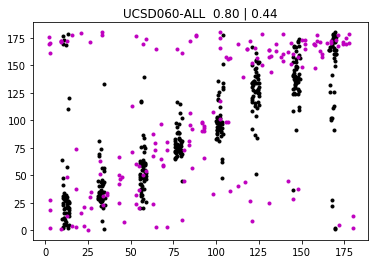

In [10]:
roi='ALL'
dat = OUT_LOC_TASK[roi]
o_task = E_TASK.orient0.values.copy()
o_task[o_task<0] =180+o_task[o_task<0]
est_task = dat.est[p['runNs']==1]
est_loc = dat.est[p['runNs']==0]
plt.plot(o_task,est_task,'k.')
plt.plot(o_loc,est_loc,'m.')
plt.title('%s-%s  %.2f | %.2f' %(subj,roi,c_corr(o_task,est_task),c_corr(o_loc,est_loc)))
plt.show()

# Train and Test Task

In [30]:
# do with pool because so many blocks...
OUT_TASK_TASK = pd.Series()
p = {"nchans" : 8, "span" : 180, "ninit" : 30}
p['stimfeat'] = o_task
p['runNs'] = E_TASK.sess
runs = np.unique(p['runNs'])
for roi in DC_TASK.keys():
# for roi in ['V3']:
    print(roi)
    p['samples'] = DC_TASK[roi]# should be trials by voxels
    def run_cross_val(run):
        p["test_trials"] = (p["runNs"]==runs[run])
        OUT = DecodeSNC_CViter(p["samples"], p); 
        if type(OUT) is int:
            print(testrun_idx,'Failed')
            return OUT
        else:
            e,u,_ = OUT
            return (e,u,p["test_trials"])
    inds = np.arange(len(runs))
    with Pool(10) as P:
        BIG_OUT = P.map(run_cross_val,inds)
        
    est = np.full(n_ev_task, np.nan)
    unc = np.full(n_ev_task, np.nan)
    for b in range(len(BIG_OUT)):
        b=BIG_OUT[b]
        if type(b) is int:
            continue
        e,u,ind = b
        est[ind],unc[ind] = e,u
    OUT_TASK_TASK[roi] = pd.Series({'est':est,'unc':unc})

TO


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig

Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 2
Failed: 2


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 2
Failed: 1
Failed: 3
Failed: 1
Failed: 4
V3


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig

Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))


Failed: 2


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 2
Failed: 2
Failed: 2


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 2


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:32: RuntimeWarning: invalid value encountered in true_divide
  out = (fun_lik(s)/Integ)*np.exp(1j*s)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:32: RuntimeWarning: divide by zero encountered in true_divide
  out = (fun_lik(s)/Integ)*np.exp(1j*s)
/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:87: RuntimeWarning: invalid value encountered in multiply
  return (b-a)/2.0 * np.sum(w*func(y, *args), axis=-1), None


Failed: 3
Failed: 3
Failed: 3
Failed: 4
Failed: 1
Failed: 4
Failed: 1
Failed: 5
Failed: 2
Failed: 5


/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (600) exceeded. Latest difference = nan
  AccuracyWarning)


Failed: 3
Failed: 1
Failed: 6
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 2
Failed: 2
Failed: 7
Failed: 1
Failed: 1
Failed: 3
Failed: 1
Failed: 3
Failed: 8
Failed: 2
Failed: 4
Failed: 2
Failed: 4
Failed: 3
Failed: 1
Failed: 3
Failed: 9
Failed: 5
Failed: 5
Failed: 4
Failed: 2
Failed: 4
Failed: 6
Failed: 1
Failed: 6
Failed: 5
Failed: 3
Failed: 5
Failed: 2
Failed: 7
Failed: 4
Failed: 6
Failed: 3
Failed: 8
Failed: 4
Failed: 9
Failed: 7
Failed: 5
Failed: 5
Failed: 10
Failed: 8
Failed: 6
Failed: 11
Failed: 6
Failed: 7
Failed: 9
Failed: 12
Failed: 8
Failed: 7
Failed: 9
Failed: 13
Failed: 10
Failed: 10
Failed: 8
Failed: 14
Failed: 11
Failed: 11
Failed: 9
Failed: 15
Failed: 12
Failed: 10
Failed: 13
Failed: 14
IPS


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') 

Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 2
Failed: 2
Failed: 2
Failed: 2
Failed: 2
Failed: 2
Failed: 2
Failed: 2
Failed: 3
Failed: 3
Failed: 3
Failed: 3
Failed: 3


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 4
Failed: 4
Failed: 4
Failed: 4
Failed: 1
Failed: 5
Failed: 5
Failed: 5
Failed: 1
Failed: 1
Failed: 6
Failed: 1
Failed: 6
Failed: 6
Failed: 2
Failed: 2
Failed: 2
Failed: 7
Failed: 3
Failed: 3
Failed: 3
Failed: 1
Failed: 8
Failed: 1
Failed: 1
Failed: 4
Failed: 4
Failed: 2
Failed: 9
Failed: 1
Failed: 2
Failed: 2
Failed: 5
Failed: 5
Failed: 1
Failed: 10
Failed: 3
Failed: 2
Failed: 3
Failed: 1
Failed: 3
Failed: 6
Failed: 6
Failed: 4
Failed: 11
Failed: 2
Failed: 4
Failed: 1
Failed: 2
Failed: 3
Failed: 4
Failed: 7
Failed: 3
Failed: 7
Failed: 5
Failed: 5
Failed: 3
Failed: 4
Failed: 8
Failed: 8
Failed: 5
Failed: 5
Failed: 9
Failed: 9
Failed: 6
Failed: 7
Failed: 10
Failed: 10
Failed: 8
Failed: 11
Failed: 11
Failed: 12
Failed: 12
Failed: 13
Failed: 13
Failed: 14
Failed: 14
Failed: 15
Failed: 16
Failed: 17
Failed: 18
Failed: 19
LO


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig

/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 2
Failed: 2
Failed: 2
Failed: 2
Failed: 3
Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 2
Failed: 2
Failed: 3
Failed: 1
Failed: 4
Failed: 1
Failed: 1
Failed: 1
Failed: 2
Failed: 2
Failed: 3
Failed: 4
hv4


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig

/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 2
Failed: 2
Failed: 2
Failed: 1
Failed: 3
Failed: 3
Failed: 1
Failed: 4
Failed: 1
Failed: 1
Failed: 1
Failed: 2
Failed: 5
Failed: 2
Failed: 2
Failed: 2
Failed: 3
Failed: 1
Failed: 3
Failed: 1
Failed: 4
Failed: 1
Failed: 5
Failed: 6
VO


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig

/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 2
Failed: 2
Failed: 3
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 2
Failed: 2
Failed: 2
Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 2
Failed: 2
Failed: 2
Failed: 3
Failed: 3
Failed: 4
V2


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube

/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 2
Failed: 2
Failed: 3
Failed: 4
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 1
Failed: 5


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:65: RuntimeWarning: invalid value encountered in sqrt
  unc[i] = np.sqrt(-2*np.log(np.abs(E1)))/pi*90


Failed: 1
Failed: 6
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:65: RuntimeWarning: invalid value encountered in sqrt
  unc[i] = np.sqrt(-2*np.log(np.abs(E1)))/pi*90


V1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube

/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27


Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))


Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 2
Failed: 2
Failed: 2
Failed: 2
Failed: 2
Failed: 3


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:65: RuntimeWarning: invalid value encountered in sqrt
  unc[i] = np.sqrt(-2*np.log(np.abs(E1)))/pi*90


Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 2
Failed: 2
Failed: 2
Failed: 1
Failed: 2
Failed: 1
Failed: 3
Failed: 2
Failed: 4
Failed: 5
ALL


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig

Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 2


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 3


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 1
Failed: 1
Failed: 2
Failed: 2
Failed: 1
Failed: 1
Failed: 3
Failed: 2
Failed: 2
Failed: 1
Failed: 1
Failed: 4
Failed: 3
Failed: 1
Failed: 5
Failed: 4
Failed: 2
Failed: 6
Failed: 3
Failed: 4
Failed: 5
Failed: 6
Failed: 7
Failed: 8
Failed: 9
Failed: 10


# Organize Noise data for plotting

In [31]:
roi = 'V2'
c_mean_loc_task = OUT_LOC_TASK[roi]['est'][n_ev_loc:]
c_mean_task_task = OUT_TASK_TASK[roi]['est']
c_mean_loc_loc = OUT_LOC_LOC[roi]['est']


Text(0.5,1,'V2 Tr:L, Tst:L $p=$ 0.265')

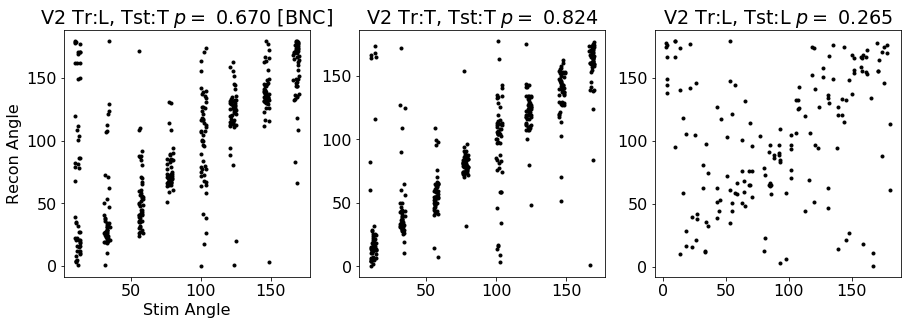

In [32]:
angs = np.floor(E_Donut.d0.values).astype(int)
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(o_task,c_mean_loc_task,'k.')
cc_good = nanc_corr(o_task,c_mean_loc_task)
plt.title('%s Tr:L, Tst:T $p=$ %.3f [BNC]' %(roi,cc_good))
plt.xlabel('Stim Angle')
plt.ylabel('Recon Angle')

plt.subplot(232)
plt.plot(o_task,c_mean_task_task,'k.')
cc_good = nanc_corr(o_task,c_mean_task_task)
plt.title('%s Tr:T, Tst:T $p=$ %.3f' %(roi,cc_good))

plt.subplot(233)
plt.plot(angs,c_mean_loc_loc,'k.')
cc_good = nanc_corr(angs,c_mean_loc_loc)
plt.title('%s Tr:L, Tst:L $p=$ %.3f' %(roi,cc_good))

# Visualize Serial Bias

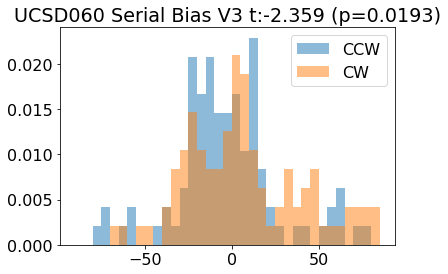

In [18]:
E_recon = c_mean_loc_task - o_task
E_recon[np.abs(E_recon)>90] = 180 - E_recon[np.abs(E_recon)>90]*np.sign(E_recon[np.abs(E_recon)>90])

grp0 = (E_TASK.SB==-1)&(E_TASK.cardinal==0)#&~good
grp2 = (E_TASK.SB==1)&(E_TASK.cardinal==0)#&~good

SB_CCW = E_recon[grp0]
SB_CW = E_recon[grp2]
bns = np.arange(-90,90,5)
plt.hist(SB_CCW,alpha=.5,bins=bns,density=True)
plt.hist(SB_CW,alpha=.5,bins=bns,density=True)

ts = stats.ttest_ind(SB_CCW,SB_CW)
plt.legend(('CCW','CW'))
plt.title('%s Serial Bias %s t:%.3f (p=%.4f)' %(subj,roi,ts[0],ts[1]))
plt.show()

# Train and Test IEM for all ROIS

In [19]:
# fit IEM to data
# LOC -> MEM
M_all = IEM2.build_model(E_LOC,DC_LOC,donut_thresh=0,anova_thresh=0,pre_cleaned=1)
OUT = IEM2.fit_model(M_all,DC_TASK,pre_cleaned=1) 
# MEM->MEM
this_out_task = IEM.fit_by_roi(DC_TASK_T,ang=np.round(E_TASK.orient0.values).astype(int),G=E_TASK.sess,center=0)
# LOC->LOC
this_out_loc = IEM.fit_by_roi(DC_LOC_T,ang=np.floor(E_Donut.d0.values).astype(int),G=E_Donut.sess,center=0)

In [33]:
roi = 'V2'
this_dat = OUT[roi]
n_trials = len(E_TASK)
iem_locs = np.arange(0,180)/90*np.pi+np.pi/180
iem_locs = np.tile(iem_locs,(n_trials,1))
c_mean = pycircstat.mean(iem_locs,this_dat,axis=1)
c_mean[c_mean>np.pi]-=np.pi*2
c_mean*=90/np.pi
c_mean+=90
c_mean_loc_task = c_mean
output_cent_loc_task = IEM2.center_resp(this_dat,np.round(o_task).astype(int))

# TASK TASK
this_dat = this_out_task[roi]
n_trials = len(E_TASK)
iem_locs = np.arange(0,180)/90*np.pi+np.pi/180
iem_locs = np.tile(iem_locs,(n_trials,1))
c_mean = pycircstat.mean(iem_locs,this_dat,axis=1)
c_mean*=90/np.pi
c_mean_task_task = c_mean
output_cent_task_task = IEM2.center_resp(this_dat,np.round(o_task).astype(int))

# LOC LOC
this_dat = this_out_loc[roi]
angs = np.floor(E_Donut.d0.values).astype(int)
n_trials = len(E_Donut)
iem_locs = np.arange(0,180)/90*np.pi+np.pi/180
iem_locs = np.tile(iem_locs,(n_trials,1))
c_mean = pycircstat.mean(iem_locs,this_dat,axis=1)
c_mean_og = c_mean.copy()
c_mean*=90/np.pi
c_mean_loc_loc = c_mean
output_cent_loc_loc = IEM2.center_resp(this_dat,angs)

# Visaulize Reconstruction Fidelity IEM

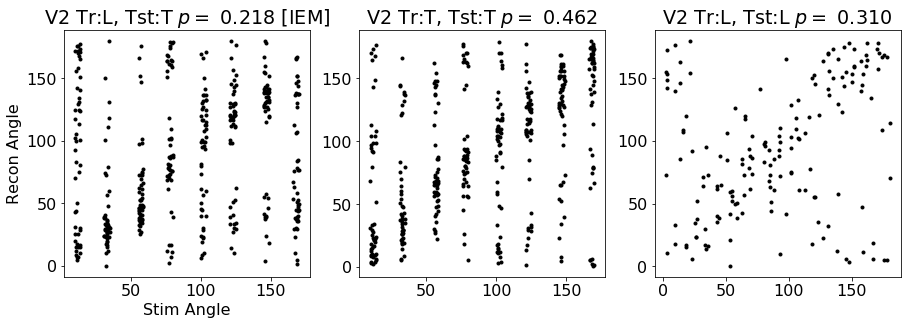

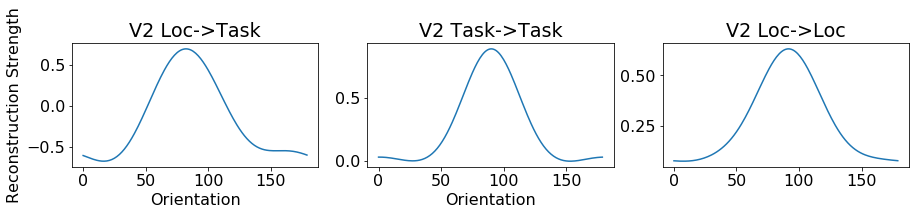

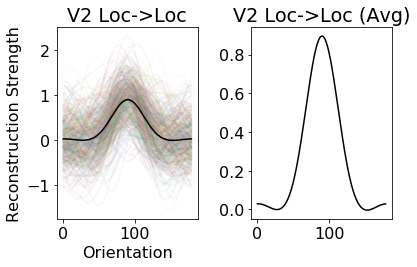

In [34]:
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(o_task,c_mean_loc_task,'k.')
cc_good = c_corr(o_task,c_mean_loc_task)
plt.title('%s Tr:L, Tst:T $p=$ %.3f [IEM]' %(roi,cc_good))
plt.xlabel('Stim Angle')
plt.ylabel('Recon Angle')

plt.subplot(232)
plt.plot(o_task,c_mean_task_task,'k.')
cc_good = nanc_corr(o_task,c_mean_task_task)
plt.title('%s Tr:T, Tst:T $p=$ %.3f' %(roi,cc_good))

plt.subplot(233)
plt.plot(angs,c_mean_loc_loc,'k.')
cc_good = c_corr(angs,c_mean_loc_loc)
plt.title('%s Tr:L, Tst:L $p=$ %.3f' %(roi,cc_good))
# plt.show()

plt.figure(figsize=(15,5))
plt.subplot(234)
plt.plot(np.mean(output_cent_loc_task,0))
plt.title('%s Loc->Task' %roi)
plt.xlabel('Orientation')
plt.ylabel('Reconstruction Strength')
plt.subplot(235)
plt.plot(np.mean(output_cent_task_task,0))
plt.title('%s Task->Task' %roi)
plt.xlabel('Orientation')
plt.subplot(236)
plt.plot(np.mean(output_cent_loc_loc,0))
plt.title('%s Loc->Loc' %roi)
plt.show()

plt.subplot(1,2,1)
plt.plot(output_cent_task_task.T,alpha=.05)
plt.plot(np.mean(output_cent_task_task,0),'k')
plt.title('%s Loc->Loc' %roi)
plt.xlabel('Orientation')
plt.ylabel('Reconstruction Strength')
plt.subplot(1,2,2)
plt.plot(np.mean(output_cent_task_task,0),'k')
plt.title('%s Loc->Loc (Avg)' %roi)
plt.tight_layout()
plt.show()

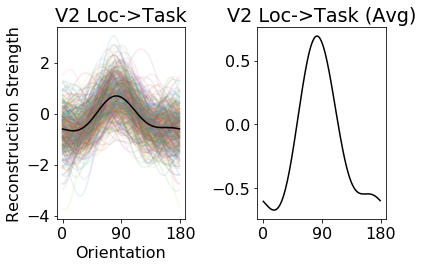

In [22]:
# dat = output_cent_loc_loc
# plt.subplot(1,2,1)
# plt.plot(dat.T,alpha=.1)
# plt.plot(np.mean(dat,0),'k')
# plt.axis('tight')
# plt.title('%s Loc->Loc' %roi)
# plt.xlabel('Orientation')
# plt.ylabel('Reconstruction Strength')
# plt.subplot(1,2,2)
# plt.plot(np.mean(dat,0),'k')
# plt.title('%s Loc->Loc (Avg)' %roi)
# plt.tight_layout()
# plt.show()

dat = output_cent_loc_task
plt.subplot(1,2,1)
plt.plot(dat.T,alpha=.1)
plt.plot(np.mean(dat,0),'k')
plt.xticks((0,90,180))
plt.title('%s Loc->Task' %roi)
plt.xlabel('Orientation')
plt.ylabel('Reconstruction Strength')
plt.subplot(1,2,2)
plt.plot(np.mean(dat,0),'k')
plt.title('%s Loc->Task (Avg)' %roi)
plt.xticks((0,90,180))
plt.tight_layout()
plt.show()

# Visualize Serial and Cardinal Biases

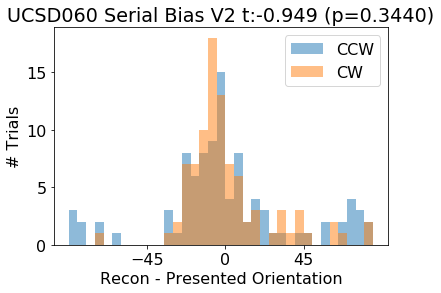

In [23]:
# look at sign of recon error relative to SB
E_recon = c_mean_loc_task - o_task
E_recon[np.abs(E_recon)>90] = 180 - E_recon[np.abs(E_recon)>90]*np.sign(E_recon[np.abs(E_recon)>90])

grp0 = (E_TASK.SB==-1)&(E_TASK.cardinal==0)#&~good
grp2 = (E_TASK.SB==1)&(E_TASK.cardinal==0)#&~good

SB_CCW = E_recon[grp0]
SB_CW = E_recon[grp2]
bns = np.arange(-90,90,5)
plt.hist(SB_CCW,alpha=.5,bins=bns)
plt.hist(SB_CW,alpha=.5,bins=bns)

ts = stats.ttest_ind(SB_CCW,SB_CW)
plt.legend(('CCW','CW'))
plt.title('%s Serial Bias %s t:%.3f (p=%.4f)' %(subj,roi,ts[0],ts[1]))
plt.xlabel('Recon - Presented Orientation')
plt.ylabel('# Trials')
plt.xticks([-45,0,45])
plt.show()

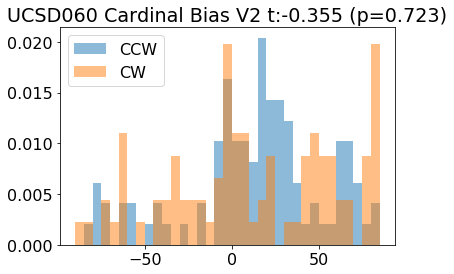

In [24]:
grp0 = (E_TASK.CB==-1)#&~good
grp2 = (E_TASK.CB==1)#&~good
CB_CCW = E_recon[grp0]
CB_CW = E_recon[grp2]

bns = np.arange(-90,90,5)
plt.hist(CB_CCW,alpha=.5,bins=bns,density=True)
plt.hist(CB_CW,alpha=.5,bins=bns,density=True)

ts = stats.ttest_ind(CB_CCW,CB_CW)
plt.legend(('CCW','CW'))
plt.title('%s Cardinal Bias %s t:%.3f (p=%.3f)' %(subj,roi,ts[0],ts[1]))
plt.show()

# Quantify correlations and biases for IEM

In [25]:
corr_coefs = pd.DataFrame()
BIAS_IEM = pd.DataFrame()
cc_key = ['LocTask','TaskTask','LocLoc']
train_on_key = ['Loc','Task']
uncert_key = ['poor','all']
roi_want = ['V1','V2','V3','hv4','IPS','ALL']
iem_base = np.arange(0,180)/90*np.pi+np.pi/180
n_trials_task = len(E_TASK)
n_trials_loc = len(E_Donut)

for roi in roi_want:
    
    # Task Loc
    this_dat = OUT[roi]
    iem_locs = np.tile(iem_base,(n_trials_task,1))
    c_mean = pycircstat.mean(iem_locs,this_dat,axis=1)
    c_mean[c_mean>np.pi]-=np.pi*2
    c_mean*=90/np.pi
    c_mean+=90
    c_mean_loc_task = c_mean

    # TASK TASK
    this_dat = this_out_task[roi]
    iem_locs = np.tile(iem_base,(n_trials_task,1))
    c_mean = pycircstat.mean(iem_locs,this_dat,axis=1)
    c_mean*=90/np.pi
    c_mean_task_task = c_mean

    # LOC LOC
    this_dat = this_out_loc[roi]
    angs = np.floor(E_Donut.d0.values).astype(int)
    iem_locs = np.tile(iem_base,(n_trials_loc,1))
    c_mean = pycircstat.mean(iem_locs,this_dat,axis=1)
    c_mean_og = c_mean.copy()
    c_mean*=90/np.pi
    c_mean_loc_loc = c_mean
    
    # Circular Correlations
    cc = np.zeros(3)
    cc[0] = c_corr(o_task,c_mean_loc_task)
    cc[1] = c_corr(o_task,c_mean_task_task)
    cc[2] = c_corr(angs,c_mean_loc_loc)
    for i in range(3):
        c = pd.Series({'ROI':roi,'corr':cc[i],'type':cc_key[i]})
        corr_coefs = corr_coefs.append(c,ignore_index=True)

    # serial bias stuff
    for train_on in [0,1]: # loc, task
        for uncert in [0,1]: #poor, all
            if train_on==0:
                E_recon = c_mean_loc_task - o_task
            else:
                E_recon = c_mean_task_task - o_task
            E_recon[np.abs(E_recon)>90] = 180 - E_recon[np.abs(E_recon)>90]*np.sign(E_recon[np.abs(E_recon)>90])
            if uncert==0:
                modifier = ~good_task_task
            else:
                modifier = True
            # Serial Bias
            SB_grp0 = (E_TASK.SB==-1)&(E_TASK.cardinal==0)&modifier
            SB_grp1 = (E_TASK.SB==1)&(E_TASK.cardinal==0)&modifier
            SB_CCW = E_recon[SB_grp0]
            SB_CW = E_recon[SB_grp1]
            SB_ts = stats.ttest_ind(SB_CCW,SB_CW)
            
            #Cardinal Bias
            CB_grp0 = (E_TASK.CB==-1)&modifier
            CB_grp1 = (E_TASK.CB==1)&modifier
            CB_CCW = E_recon[CB_grp0]
            CB_CW = E_recon[CB_grp1]
            CB_ts = stats.ttest_ind(CB_CCW,CB_CW)
            
            # Store
            this_S = pd.Series({'ROI':roi,'Train':train_on_key[train_on],'Uncert':uncert_key[uncert],
                                'SB_T':SB_ts[0],'SB_p':np.log(SB_ts[1]),'CB_T':CB_ts[0],'CB_p':np.log(CB_ts[1])})
            BIAS_IEM=BIAS_IEM.append(this_S,ignore_index=True)

NameError: name 'good_task_task' is not defined

# Quantify SNC Model

In [1045]:
corr_coefs_SNC = pd.DataFrame()
BIAS_SNC = pd.DataFrame()


for roi in roi_want:
    this_dat = OUT_LOC_TASK[roi]
    c_mean_loc_task = OUT_LOC_TASK[roi]['est'][n_ev_loc:]
    unc_loc_task = OUT_LOC_TASK[roi]['unc'][n_ev_loc:] 
    good_loc_task = unc_loc_task>np.nanmedian(unc_loc_task)

    # TASK TASK
    c_mean_task_task =  OUT_TASK_TASK[roi]['est']
    unc_task_task =  OUT_TASK_TASK[roi]['unc']
    good_task_task  = unc_task_task>np.nanmedian(unc_task_task)

    # LOC LOC
    angs = np.floor(E_Donut.d0.values).astype(int)
    c_mean_loc_loc = OUT_LOC_LOC[roi]['est']
    unc_loc_loc = OUT_LOC_LOC[roi]['unc']
    good_loc_loc = unc_loc_loc>np.nanmedian(unc_loc_loc)

    cc = np.zeros(3)
    cc[0] = c_corr(o_task,c_mean_loc_task)
    cc[1] = c_corr(o_task,c_mean_task_task)
    cc[2] = c_corr(angs,c_mean_loc_loc)
    for i in range(3):
        c = pd.Series({'ROI':roi,'corr':cc[i],'type':cc_key[i]})
        corr_coefs_SNC = corr_coefs_SNC.append(c,ignore_index=True)

    # serial bias stuff
    for train_on in [0,1]: # loc, task
        for uncert in [0,1]: #poor, all
            if train_on==0:
                E_recon = c_mean_loc_task - o_task
                good = good_loc_task
            else:
                E_recon = c_mean_task_task - o_task
                good = good_task_task
            E_recon[np.abs(E_recon)>90] = 180 - E_recon[np.abs(E_recon)>90]*np.sign(E_recon[np.abs(E_recon)>90])
            if uncert==0:
                modifier = ~good
            else:
                modifier = True
            SB_grp0 = (E_TASK.SB==-1)&(E_TASK.cardinal==0)&modifier
            SB_grp1 = (E_TASK.SB==1)&(E_TASK.cardinal==0)&modifier
            SB_CCW = E_recon[SB_grp0]
            SB_CW = E_recon[SB_grp1]
            SB_ts = stats.ttest_ind(SB_CCW,SB_CW)
            
            CB_grp0 = (E_TASK.CB==-1)&modifier
            CB_grp1 = (E_TASK.CB==1)&modifier
            CB_CCW = E_recon[CB_grp0]
            CB_CW = E_recon[CB_grp1]
            CB_ts = stats.ttest_ind(CB_CCW,CB_CW)
            
            this_S = pd.Series({'ROI':roi,'Train':train_on_key[train_on],'Uncert':uncert_key[uncert],
                                'SB_T':SB_ts[0],'SB_p':np.log(SB_ts[1]),'CB_T':CB_ts[0],'CB_p':np.log(CB_ts[1])})
            BIAS_SNC = BIAS_SNC.append(this_S,ignore_index=True)

/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/circ_corr.py:13: RuntimeWarning: invalid value encountered in greater
  if np.any(y>90): yu = yu.astype(float); yu/=90*np.pi
/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


# Quantify Both

In [35]:
corr_coefs_B = pd.DataFrame()
BIAS_B = pd.DataFrame()

for roi in roi_want:
    for model_use in ['SNC','IEM']:
        if model_use=='SNC':
            this_dat = OUT_LOC_TASK[roi]
            c_mean_loc_task = OUT_LOC_TASK[roi]['est'][n_ev_loc:]
            unc_loc_task = OUT_LOC_TASK[roi]['unc'][n_ev_loc:] 
            good_loc_task = unc_loc_task>np.nanmedian(unc_loc_task)

            # TASK TASK
            c_mean_task_task =  OUT_TASK_TASK[roi]['est']
            unc_task_task =  OUT_TASK_TASK[roi]['unc']
            good_task_task  = unc_task_task>np.nanmedian(unc_task_task)

            # LOC LOC
            angs = np.floor(E_Donut.d0.values).astype(int)
            c_mean_loc_loc = OUT_LOC_LOC[roi]['est']
            unc_loc_loc = OUT_LOC_LOC[roi]['unc']
            good_loc_loc = unc_loc_loc>np.nanmedian(unc_loc_loc)
        elif model_use=='IEM':
            # Task Loc
            this_dat = OUT[roi]
            iem_locs = np.tile(iem_base,(n_trials_task,1))
            c_mean = pycircstat.mean(iem_locs,this_dat,axis=1)
            c_mean[c_mean>np.pi]-=np.pi*2
            c_mean*=90/np.pi
            c_mean+=90
            c_mean_loc_task = c_mean

            # TASK TASK
            this_dat = this_out_task[roi]
            iem_locs = np.tile(iem_base,(n_trials_task,1))
            c_mean = pycircstat.mean(iem_locs,this_dat,axis=1)
            c_mean*=90/np.pi
            c_mean_task_task = c_mean

            # LOC LOC
            this_dat = this_out_loc[roi]
            angs = np.floor(E_Donut.d0.values).astype(int)
            iem_locs = np.tile(iem_base,(n_trials_loc,1))
            c_mean = pycircstat.mean(iem_locs,this_dat,axis=1)
            c_mean_og = c_mean.copy()
            c_mean*=90/np.pi
            c_mean_loc_loc = c_mean

        cc = np.zeros(3)
        cc[0] = nanc_corr(o_task,c_mean_loc_task)
        cc[1] = nanc_corr(o_task,c_mean_task_task)
        cc[2] = nanc_corr(angs,c_mean_loc_loc)
        for i in range(3):
            c = pd.Series({'Model':model_use,'ROI':roi,'corr':cc[i],'type':cc_key[i]})
            corr_coefs_B = corr_coefs_B.append(c,ignore_index=True)

        # serial bias stuff
        for train_on in [0,1]: # loc, task
            for uncert in [0,1]: #poor, all
                if train_on==0:
                    E_recon = c_mean_loc_task - o_task
                    good = good_loc_task
                else:
                    E_recon = c_mean_task_task - o_task
                    good = good_task_task
                E_recon[np.abs(E_recon)>90] = 180 - E_recon[np.abs(E_recon)>90]*np.sign(E_recon[np.abs(E_recon)>90])
                if uncert==0:
                    modifier = ~good
                else:
                    modifier = True
                SB_grp0 = (E_TASK.SB==-1)&(E_TASK.cardinal==0)&modifier
                SB_grp1 = (E_TASK.SB==1)&(E_TASK.cardinal==0)&modifier
                SB_CCW = E_recon[SB_grp0]
                SB_CW = E_recon[SB_grp1]
                SB_ts = stats.ttest_ind(SB_CCW[~np.isnan(SB_CCW)],SB_CW[~np.isnan(SB_CW)])
                SB_d = np.nanmean(SB_CCW) - np.nanmean(SB_CW)

                CB_grp0 = (E_TASK.CB==-1)&modifier
                CB_grp1 = (E_TASK.CB==1)&modifier
                CB_CCW = E_recon[CB_grp0]
                CB_CW = E_recon[CB_grp1]
                
                CB_ts = stats.ttest_ind(CB_CCW[~np.isnan(CB_CCW)],CB_CW[~np.isnan(CB_CW)])

                this_S = pd.Series({'Model':model_use,'ROI':roi,'Train':train_on_key[train_on],'Uncert':uncert_key[uncert],
                                    'SB_T':SB_ts[0],'SB_p':np.log(SB_ts[1]),'CB_T':CB_ts[0],'CB_p':np.log(CB_ts[1]),'SB_d':SB_d})
                BIAS_B = BIAS_B.append(this_S,ignore_index=True)

/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater


(-0.1, 1.0)

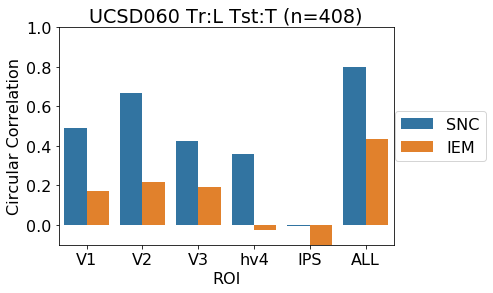

In [36]:
sns.barplot(x='ROI',y='corr',hue='Model',data=corr_coefs_B[corr_coefs_B.type=='LocTask'])
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.ylabel('Circular Correlation')
plt.title('%s Tr:L Tst:T (n=%d)' %(subj,n_trials_task))
plt.ylim(-.1,1.0)

(-0.1, 1.0)

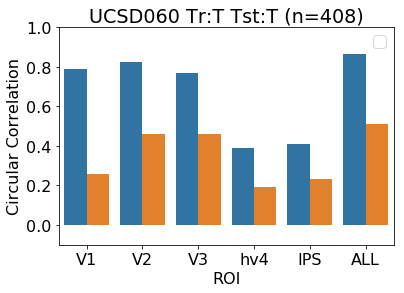

In [37]:
sns.barplot(x='ROI',y='corr',hue='Model',data=corr_coefs_B[corr_coefs_B.type=='TaskTask'])
# plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.legend('')
plt.ylabel('Circular Correlation')
plt.title('%s Tr:T Tst:T (n=%d)' %(subj,n_trials_task))
plt.ylim(-.1,1.0)

Text(0.5,1,'UCSD060 Serial Bias ')

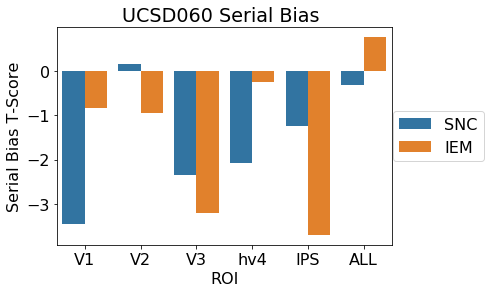

In [38]:
sns.barplot(x='ROI',y='SB_T',hue='Model',data=BIAS_B[(BIAS_B.Uncert=='all')&(BIAS_B.Train=='Loc')])
plt.ylabel('Serial Bias T-Score')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.title('%s Serial Bias ' %subj)

Text(0.5,1,'UCSD060 Serial Bias (TaskTask)')

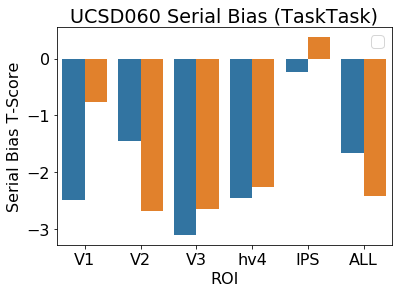

In [39]:
sns.barplot(x='ROI',y='SB_T',hue='Model',data=BIAS_B[(BIAS_B.Uncert=='all')&(BIAS_B.Train=='Task')])
plt.ylabel('Serial Bias T-Score')
# plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.legend('')
plt.title('%s Serial Bias (TaskTask)' %subj)

Text(0.5,1,'UCSD060 Serial Bias (TaskTask)')

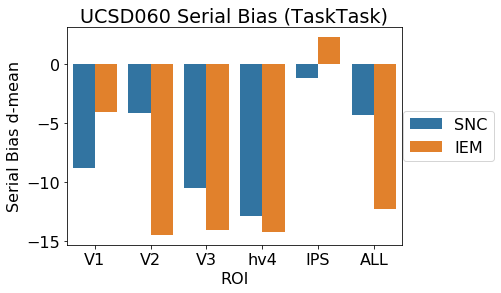

In [40]:
sns.barplot(x='ROI',y='SB_d',hue='Model',data=BIAS_B[(BIAS_B.Uncert=='all')&(BIAS_B.Train=='Task')])
plt.ylabel('Serial Bias d-mean')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.title('%s Serial Bias (TaskTask)' %subj)

/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


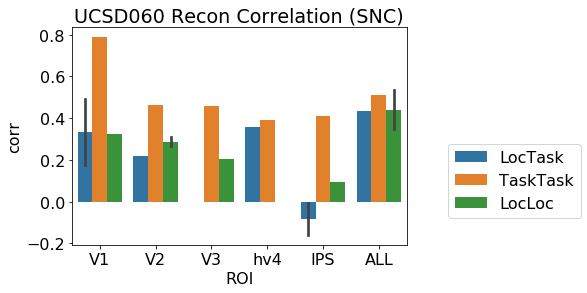

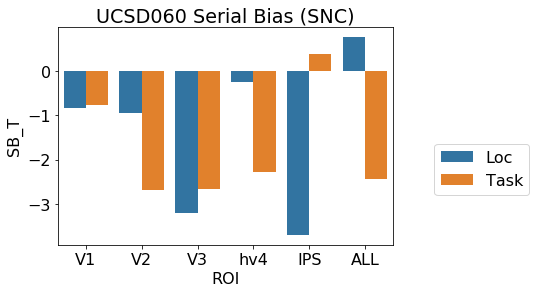

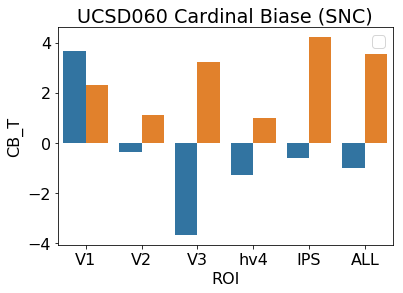

In [55]:
# summary visualize IEM
mod = 'SNC'
corr_coefs = corr_coefs_B[(BIAS_B.Model=='SNC')]
BIAS_USE = BIAS_B[(BIAS_B.Uncert=='all')&(BIAS_B.Model=='IEM')]
sns.barplot(x='ROI',hue='type',y='corr',data=corr_coefs)
plt.legend( bbox_to_anchor=(1.1, 0.5))
plt.title('%s Recon Correlation (%s)' %(subj,mod))
plt.show()

sns.barplot(x='ROI',hue='Train',y='SB_T',data=BIAS_USE)
plt.title('%s Serial Bias (%s)' %(subj,mod))
plt.legend( bbox_to_anchor=(1.1, 0.5))
plt.show()

sns.barplot(x='ROI',hue='Train',y='CB_T',data=BIAS_USE)
plt.title('%s Cardinal Biase (%s)' %(subj,mod))
plt.legend('')
plt.show()

In [53]:
BIAS_B.head()

,CB_T,CB_p,Model,ROI,SB_T,SB_d,SB_p,Train,Uncert
0,3.995586,-8.961928,SNC,V1,-2.152785,-10.881648,-3.387580,Loc,poor
1,3.685991,-8.136498,SNC,V1,-3.465612,-15.095742,-7.332435,Loc,all
2,-0.874709,-0.956887,SNC,V1,-1.522936,-4.726290,-2.034662,Task,poor
3,0.808138,-0.867591,SNC,V1,-2.499893,-8.842923,-4.322259,Task,all
4,3.749738,-8.092615,IEM,V1,0.120088,0.889622,-0.100197,Loc,poor


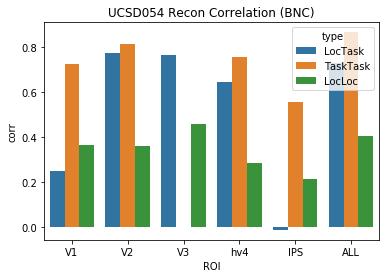

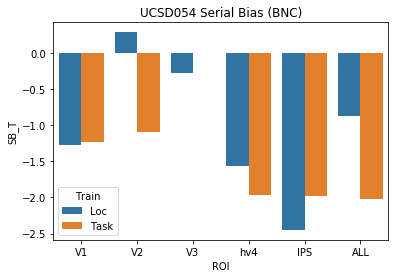

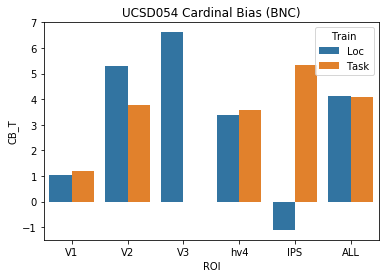

In [890]:
sns.barplot(x='ROI',hue='type',y='corr',data=corr_coefs_SNC)
plt.title('%s Recon Correlation (BNC)' %subj)
plt.show()
BIAS_USE = BIAS_SNC[BIAS_SNC.Uncert=='all']

sns.barplot(x='ROI',hue='Train',y='SB_T',data=BIAS_USE)
plt.title('%s Serial Bias (BNC)' %subj)
plt.show()

sns.barplot(x='ROI',hue='Train',y='CB_T',data=BIAS_USE)
plt.title('%s Cardinal Bias (BNC)' %subj)
plt.show()

Text(0.5,1,'Basis Set (n=9)')

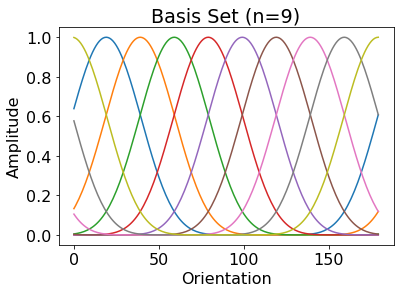

In [955]:
foo = fit_IEM_v2.gen_basis_set(1)
bar = foo[0]
plt.plot(bar)
plt.xlabel('Orientation')
plt.ylabel('Amplitude')
plt.title('Basis Set (n=9)')

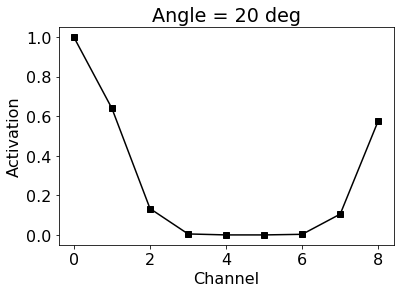

In [968]:
ang = 20
act = bar[ang,:]
plt.plot(act,'ks-')
plt.xlabel('Channel')
plt.title('Angle = %d deg' %ang)
plt.ylabel('Activation')
plt.show()